In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Out of order import that must happen before importing seet.
import torch
# If the tensor type changes we have to reload seet
torch.set_default_dtype(torch.float64)

import seet
import stereo_perception_errors
import stereo_perception_utils

## Experimental Setup

Create a scene with pass-through sensors and a display, which will visualize
points reprojected from the pass-through sensor onto a reprojection plane at a
given distance in mm.

In [2]:
error_simulator = \
    stereo_perception_errors.StereoPerceptionErrors(
        reprojection_depth_mm=5_000.0
    )

## Depth and Disparity Errors

Compute errors in depth perception for points at several depth in the scene,
and their corresponding disparity errors. Errors originate from the fact that
users see these points through the images obtained by the pass-through sensors
and rendered through the device's display. Disparity error is the lack of
vergence between the user gaze directions as it sees the rendered points. The
deviation between the best triangulation of the rendered points and their true
location, in z, is the depth error. 

Relative depth errors [%]; z = 0.25 m
Disparity error [mrad]; z = 0.25 m
Relative depth errors [%]; z = 0.50 m
Disparity error [mrad]; z = 0.50 m
Relative depth errors [%]; z = 1.00 m
Disparity error [mrad]; z = 1.00 m
Relative depth errors [%]; z = 2.50 m
Disparity error [mrad]; z = 2.50 m
Relative depth errors [%]; z = 5.00 m
Disparity error [mrad]; z = 5.00 m
Relative depth errors [%]; z = 10.00 m
Disparity error [mrad]; z = 10.00 m
Relative depth errors [%]; z = 25.00 m
Disparity error [mrad]; z = 25.00 m
Relative depth errors [%]; z = 50.00 m
Disparity error [mrad]; z = 50.00 m


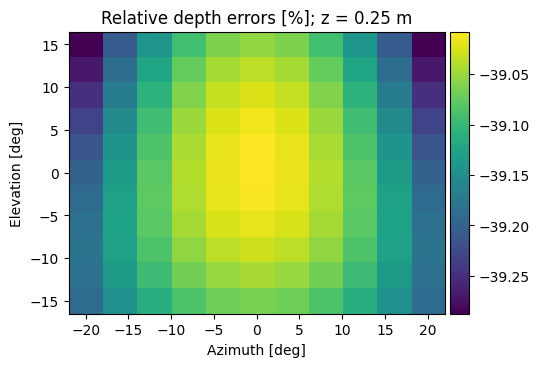

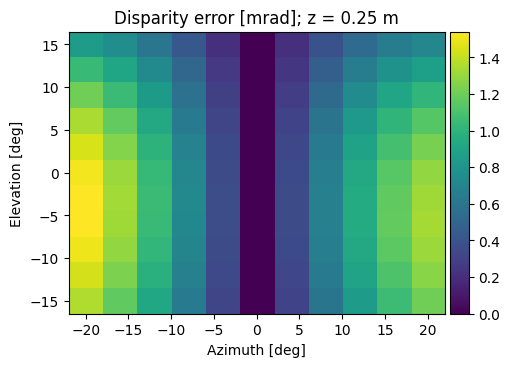

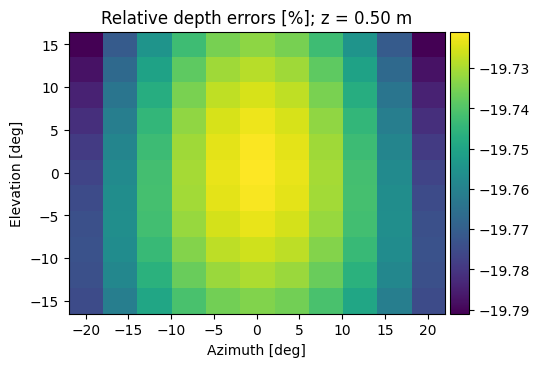

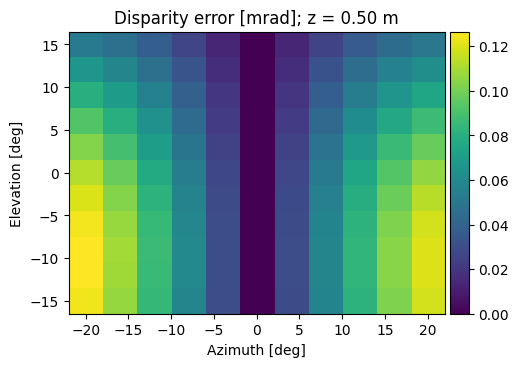

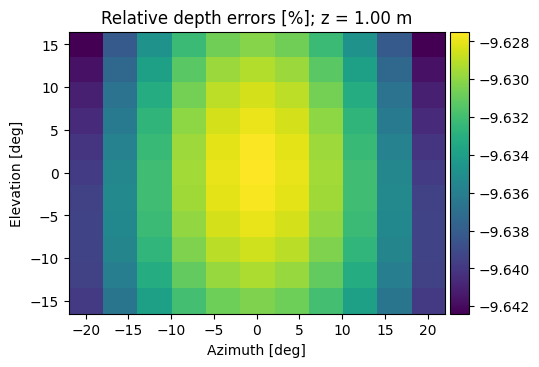

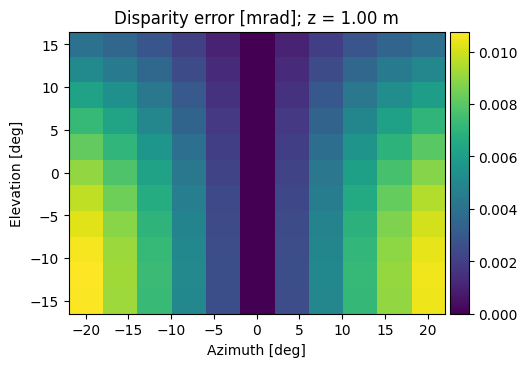

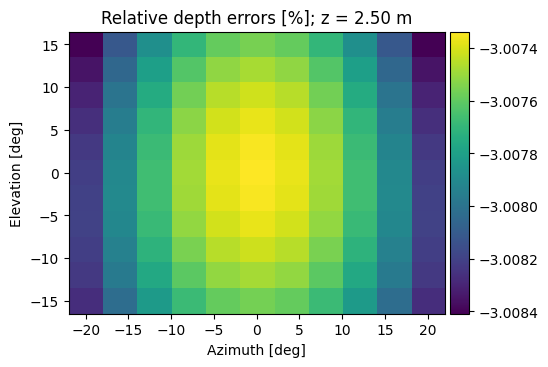

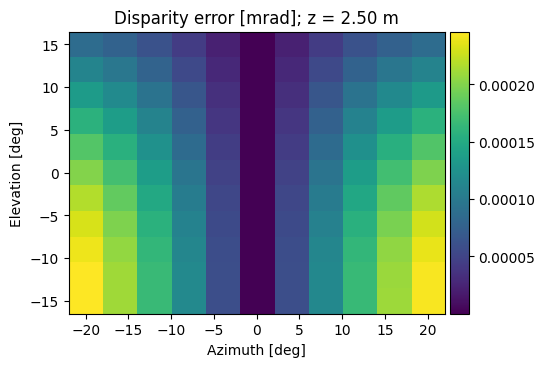

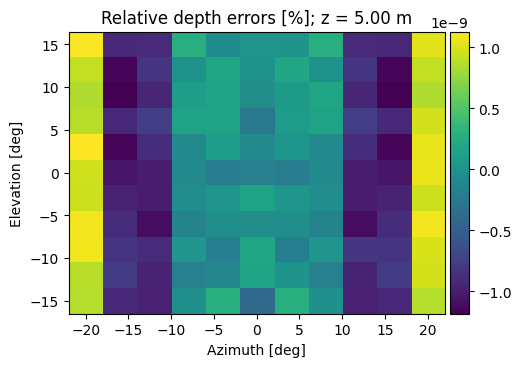

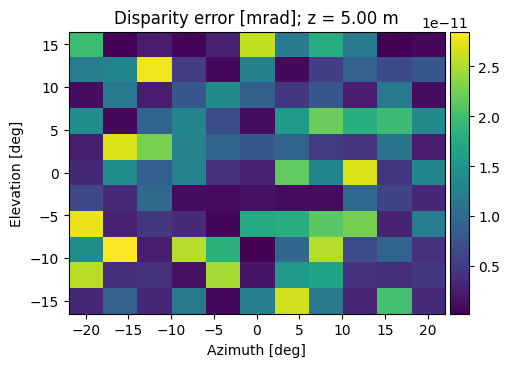

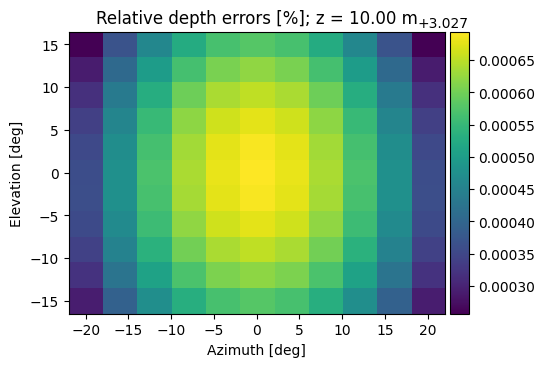

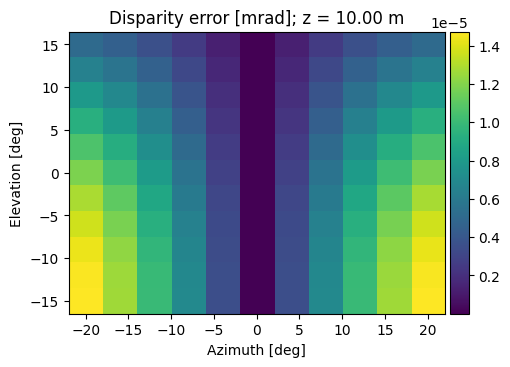

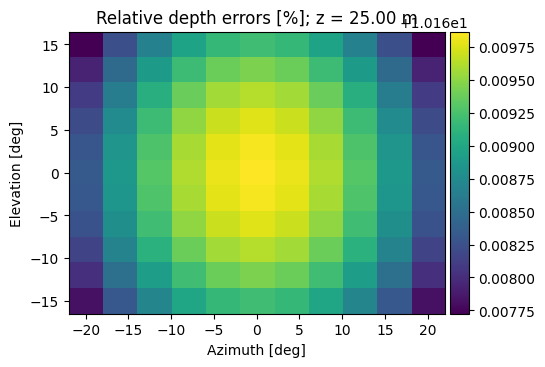

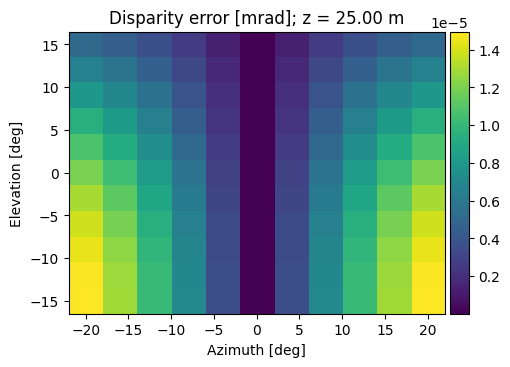

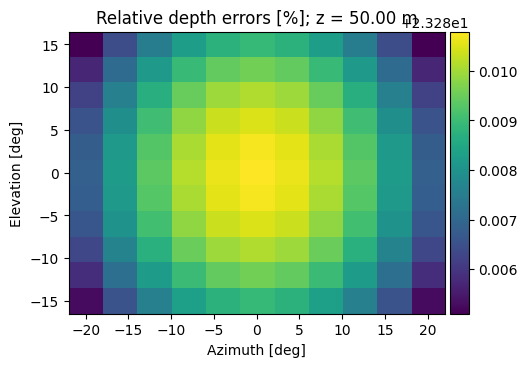

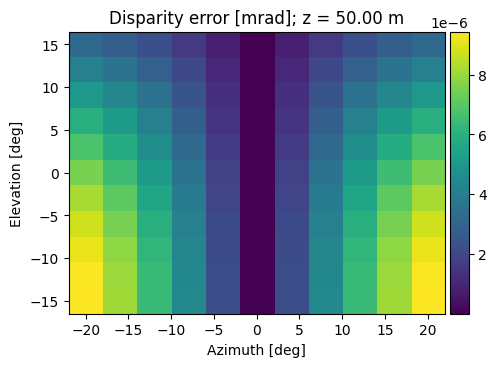

In [3]:
plt.close("all")

all_depths_mm = (
    250.0, 500.0, 1_000.0, 2_500.0, 5_000.0, 10_000.0, 25_000.0, 50_000.0
)

nrows = 11
el_deg = torch.linspace(-15, 15, nrows, requires_grad=True)
ncols = 11
az_deg = torch.linspace(-20, 20, ncols, requires_grad=True)

delta_el_deg = (el_deg[1] - el_deg[0]).item() / 2
delta_az_deg = (az_deg[1] - az_deg[0]).item() / 2

extent = \
    (
        az_deg[0].item() - delta_az_deg,
        az_deg[-1].item() + delta_az_deg,
        el_deg[0].item() - delta_el_deg,
        el_deg[-1].item() + delta_el_deg
    )

def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)

    ax.figure.set_size_inches(figw, figh)

all_grid_points = list()
all_observed_points = list()

for depth_mm in all_depths_mm:
    grid_points_inUser = \
        stereo_perception_utils.sample_points_on_plane(
            error_simulator, depth_mm, az_deg, el_deg
        )
    all_grid_points = all_grid_points + [grid_points_inUser, ]

    observed_points_inUser, \
        disparities_mrad = \
        stereo_perception_utils.compute_errors_at_grid(
            error_simulator, grid_points_inUser
        )
    all_observed_points = all_observed_points + [observed_points_inUser, ]

    # Plot depth errors.
    obs = torch.stack([torch.vstack(row) for row in observed_points_inUser])
    grid = torch.stack([torch.vstack(row) for row in grid_points_inUser])
    delta_z = obs[:, :, -1] - grid[:, :, -1]
    rel_error = (100 * delta_z / grid[:, :, -1]).clone().detach()

    title = "Relative depth errors [%]; z = {0:.2f} m".format(depth_mm / 1000)
    print(title)

    fig, ax_z = plt.subplots()
    im = ax_z.imshow(rel_error, interpolation="nearest", extent=extent)
    
    ax_z.set_title(title)
    ax_z.set_aspect("equal")
    ax_z.set_xlabel("Azimuth [deg]")
    ax_z.set_ylabel("Elevation [deg]")
    
    divider = make_axes_locatable(ax_z)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    set_size(delta_az_deg * 2, delta_el_deg * 2, ax=ax_z)

    plt.draw()

    # Plot disparity errors.
    disparity = \
        torch.stack([torch.vstack(row) for row in disparities_mrad]
    ).clone().detach()
    title = "Disparity error [mrad]; z = {0:.2f} m".format(depth_mm / 1000)
    print(title)

    fig, ax_d = plt.subplots()
    im = ax_d.imshow(disparity, interpolation="nearest", extent=extent)

    ax_d.set_title(title)
    ax_d.set_aspect("equal")
    ax_d.set_xlabel("Azimuth [deg]")
    ax_d.set_ylabel("Elevation [deg]")

    divider = make_axes_locatable(ax_d)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    set_size(delta_az_deg * 2, delta_el_deg * 2, ax=ax_d)

    plt.draw()

plt.show()

In [ ]:
import seet

J = \
    seet.core.compute_auto_jacobian_from_tensors(
        observed_points_inUser[5][5],
        grid_points_inUser[5][5]
    )
JmI = J - torch.eye(*(J.size()))
A = JmI.T @ JmI
d, V = torch.linalg.eigh(A)
i = torch.argmax(d)
v = torch.real(V[:, i])
print(v)

tensor([-1.7026e-14, -1.1773e-02, -9.9993e-01])


In [ ]:
i = torch.argmax(d)
v = torch.real(V[:, i])
v_ = J @ v
print(v)
print(v_)
print(torch.arccos(v_ @ v.T / torch.linalg.norm(v_)) / torch.pi * 180)

tensor([-1.7026e-14, -1.1773e-02, -9.9993e-01])
tensor([-2.2642e-14, -3.7996e-02, -1.8567e+00])
tensor(0.4978)


C:\Users\padossa\AppData\Local\Temp\ipykernel_52292\2424345634.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3281.)
  print(torch.arccos(v_ @ v.T / torch.linalg.norm(v_)) / torch.pi * 180)


In [ ]:
v_ @ v
torch.linalg.norm(v_)

tensor(1.8570)

In [ ]:
len(grid_points_inUser[0])

11

## Velocity Errors

As points move in the scene, their perceived locations also move. However, they
move differently, as there are errors through the rendering pipeline. We model
these errors through the difference in the velocity of the true and perceived
point. However, these errors are not isotropic, in the sense that there are
directions of the true motion of a point in space that will yield larger
discrepancy between that point's velocity and the velocity with which the point
is observed to move. We display the difference in velocity for the true
velocity that maximizes that difference.

Velocity errors [mm/s]; z = 0.25 m
Velocity errors [mm/s]; z = 0.50 m
Velocity errors [mm/s]; z = 1.00 m
Velocity errors [mm/s]; z = 2.50 m
Velocity errors [mm/s]; z = 5.00 m
Velocity errors [mm/s]; z = 10.00 m
Velocity errors [mm/s]; z = 25.00 m
Velocity errors [mm/s]; z = 50.00 m


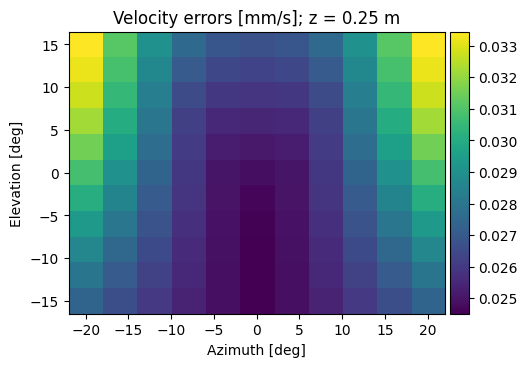

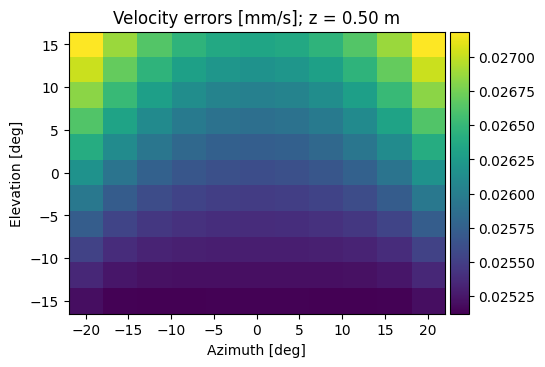

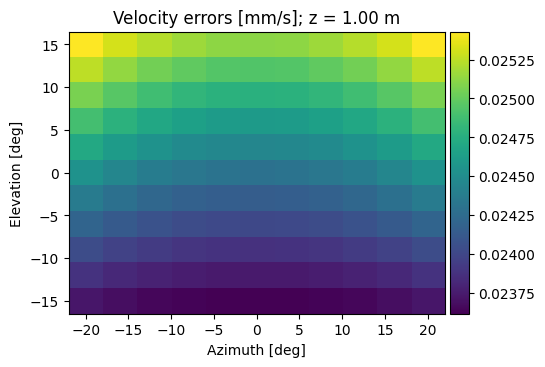

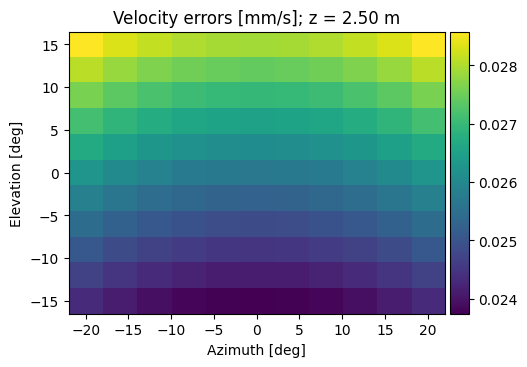

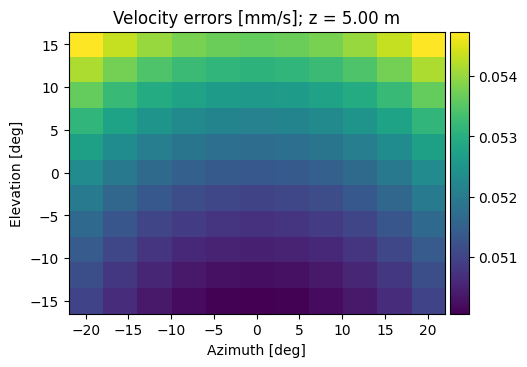

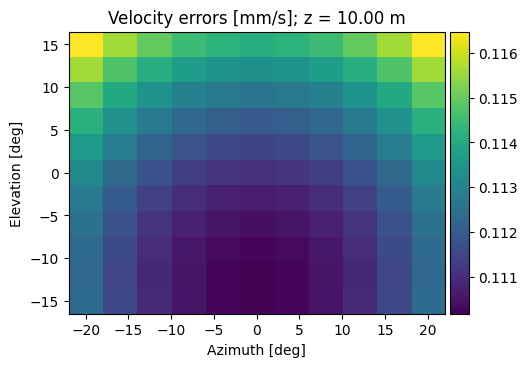

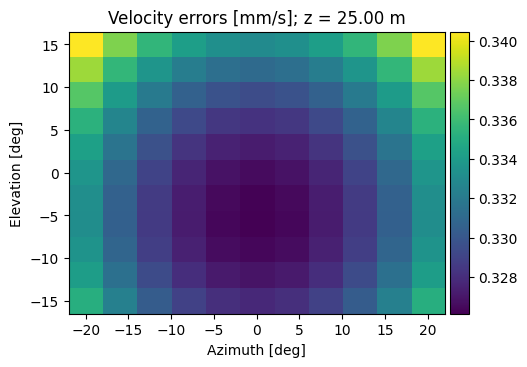

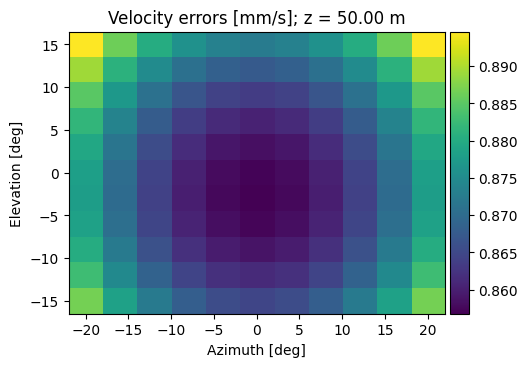

In [ ]:
# Iterate over depths.
for depth_idx, depth_mm in enumerate(all_depths_mm):
    grid_points_inUser = all_grid_points[depth_idx]

    velocity_errors_inUser = list()
    # Iterate over elevation.
    for el_idx, el_x in enumerate(grid_points_inUser):
        # Iterate over azimuth.

        velocity_errors_el_inUser = list()
        for az_idx, x in enumerate(el_x):
            y = all_observed_points[depth_idx][el_idx][az_idx]

            # J for Jacobian. This is the derivative of the observed point with
            # respect to the true point.
            J = seet.core.compute_auto_jacobian_from_tensors(y, x)

            # We seek a velocity v such that the difference between v and J@v
            # is maximal, subject to ||v|| = 1 mm/sec. Long story short, we
            # have the code below.
            JmI = J - torch.eye(*(J.shape))  # J - I
            _, V = torch.linalg.eigh(JmI.T @ JmI)
            v = V[:, -1]
            v_ = J @ v

            delta = torch.linalg.norm(v_ - v)  # No need to normalize.

            velocity_errors_el_inUser = velocity_errors_el_inUser + [delta, ]

        velocity_errors_inUser = \
            velocity_errors_inUser + [velocity_errors_el_inUser]

    # Plot.
    vel = torch.stack([torch.vstack(row) for row in velocity_errors_inUser])
    grid = torch.stack([torch.vstack(row) for row in grid_points_inUser])

    title = "Velocity errors [mm/s]; z = {0:.2f} m".format(depth_mm / 1000)
    print(title)

    fig, ax_z = plt.subplots()
    im = ax_z.imshow(vel, interpolation="nearest", extent=extent)

    ax_z.set_title(title)
    ax_z.set_aspect("equal")
    ax_z.set_xlabel("Azimuth [deg]")
    ax_z.set_ylabel("Elevation [deg]")

    divider = make_axes_locatable(ax_z)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    set_size(delta_az_deg * 2, delta_el_deg * 2, ax=ax_z)

    plt.draw()

plt.show()